In [1]:
# --------------------------------------
# Imports
# --------------------------------------

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from collections import deque
import numpy as np
from moviepy.editor import VideoFileClip
from os.path import join, basename

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pdb

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pandas as pd
    
import os.path

import random
from sklearn.utils import shuffle
import pdb

import tensorflow as tf
from tensorflow.contrib.layers import flatten
from keras.preprocessing.image import ImageDataGenerator

# Imports for Jupyter
%matplotlib inline



Using TensorFlow backend.


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# --------------------------------------
# Helper Functions
# --------------------------------------
def show_image(image, title="One Image", cmap=None, figsize=(14, 9)):
    f, ax1 = plt.subplots(1, 1, figsize=figsize)
    f.suptitle(title, fontsize=16)
    f.tight_layout()
    ax1.imshow(image, cmap=cmap)
    # ax1.set_title('First Image', fontsize=50)
    # ax2.imshow(image2, cmap=cmap2)
    # ax2.set_title('Second Image', fontsize=50)
    # plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    


---
## Load Data

In [4]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./data/train.p"
validation_file= "./data/valid.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## 1. Dataset Summary & Exploration

---

### 1.1 Basic Summary

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43
sample_index 10392


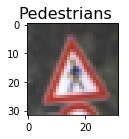

27
'Pedestrians'


In [5]:
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]

sample_index = random.randint(0, n_train)
sample_image = X_train[sample_index, :, :, :]
image_shape = sample_image.shape

n_classes = np.unique(y_train).shape[0]

sign_names = pd.Series.from_csv("signnames.csv", header=0).to_dict()
sign_names_arr = []
for i in range(len(sign_names)):
    sign_names_arr.append(sign_names[i])

    
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print("sample_index", sample_index)
show_image(sample_image, figsize=(2, 2), title=sign_names[y_train[sample_index]])


def shellquote(s):
    return "'" + s.replace("'", "'\\''") + "'"

aaa = shellquote(sign_names[y_train[sample_index]])
print(y_train[sample_index])
print(aaa)
mpimg.imsave(f'./data/image1.jpg', sample_image)



### 1.2 Visualization

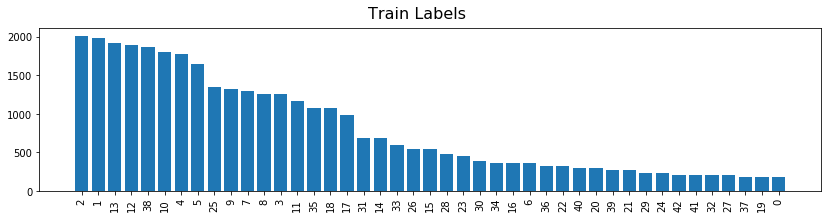

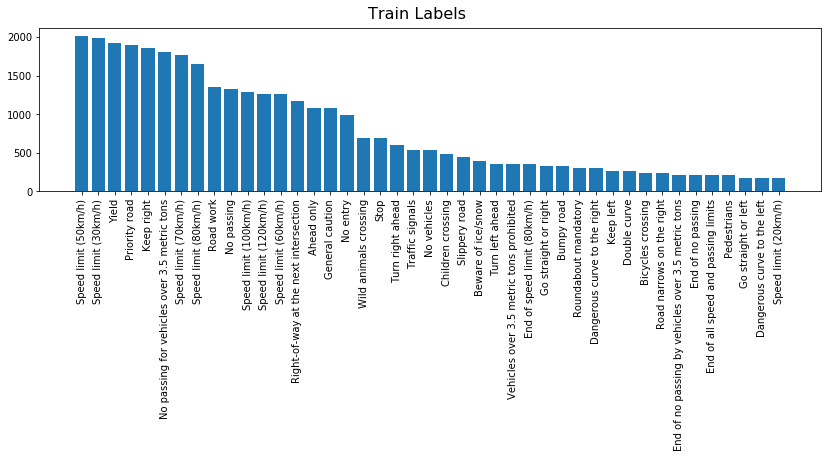

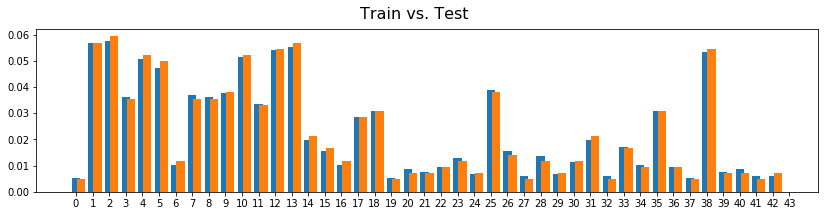

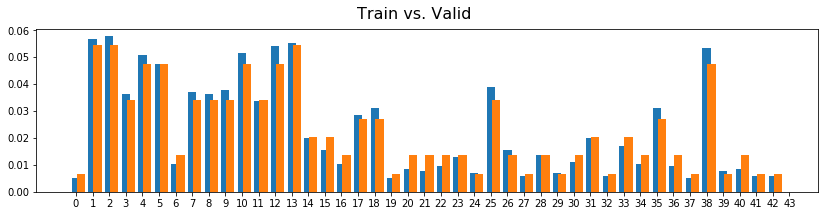

In [7]:
counts = np.unique(y_train, return_counts=True)
counts_test = np.unique(y_test, return_counts=True)
counts_valid = np.unique(y_valid, return_counts=True)

xy = zip(counts[1].tolist(), counts[0].tolist(), sign_names_arr)
xy = sorted(xy)[::-1]
x = [str(a[1]) for a in xy]
z = [a[2] for a in xy]
y = [a[0] for a in xy]

# Histogram of labels
f = plt.figure(figsize=(14,3))
f.suptitle("Train Labels", fontsize=16)
plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

# Histogram In Text Labels
f = plt.figure(figsize=(14,3))
f.suptitle("Train Labels", fontsize=16)
plt.bar(z, y)
plt.xticks(rotation=90)
plt.show()

# Label Comparison
f = plt.figure(figsize=(14,3))
f.suptitle("Train vs. Test", fontsize=16)
plt.bar(counts[0], counts[1] / sum(counts[1]), width=.5)
plt.bar(counts_test[0] + 0.3, counts_test[1] / n_test, width=.5)
plt.xticks(np.arange(0, len(counts[0])+1, 1.0))
plt.show()

# Label Comparison
f = plt.figure(figsize=(14,3))
f.suptitle("Train vs. Valid", fontsize=16)
plt.bar(counts[0], counts[1] / sum(counts[1]), width=.5)
plt.bar(counts_valid[0] + 0.3, counts_valid[1] / n_valid, width=.5)
plt.xticks(np.arange(0, len(counts[0])+1, 1.0))
plt.show()


----

## Step 2: Design and Test a Model Architecture
---

### Preprocess

1. Shuffle the training data.

2. Each image is converted to YUV color space, and we only use the Y channel.

3. I use histogram equalization to imporve contrast of the image. https://docs.opencv.org/3.1.0/d4/d1b/tutorial_histogram_equalization.html

4. I center and scale each pixel by its means and standard deviation.

In [8]:
def shuffle_training_data(X, y):
    return shuffle(X, y)    
    
def preprocess(X):
    new_X = []
    for img in X:
        img = np.expand_dims(cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:, :, 0], 2)  # Convert to YUV and keep only Y channel
        img = np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) # Improves the contrast 
    
        new_X.append(img)
        
    X = np.array(new_X)
    X = np.float32(X)

    # Standardize
    X -= np.mean(X, axis=0)
    X /= (np.std(X, axis=0) + np.finfo('float32').eps)

    return X

X_train, y_train = shuffle_training_data(X_train, y_train)
X_train_ = preprocess(X_train)
X_test_ = preprocess(X_test)
X_valid = preprocess(X_valid)

# X_train_sample, y_train_sample = shuffle(X_train, y_train, n_samples=100)
# X_test_sample, y_test_sample = shuffle(X_test, y_test, n_samples=10)
# X_train_sample = preprocess(X_train_sample)
# X_test_sample = preprocess(X_test_sample)


### Model Architecture

Layer 1: 
- Input shape is (32, 32, 1)
- Ouput shape is (32, 32, 64)
- The convolution filter is (3, 3) and has 64 channels
- Use Relu activation
- Max pool of a 2x2 square
- Drop out with a fixed probability

Layer 2: 
- Ouput shape is (16, 16, 128)
- The convolution filter is (3, 3) and has 128 channels
- Use Relu activation
- Max pool of a 2x2 square
- Drop out with a fixed probability


Layer 3:
- A fully connected layer of the dropout outputs from layer 1 and layer 2
- Input size if 24576
- Output size is 64

Layer 4:
- The logit layer
- Output the probability of each class

In [20]:
##########################
# Variables
##########################
EPOCHS = 20
BATCHES_PER_EPOCH = 5000
BATCHSIZE = 128
DROP_OUT_P = 0.5
DEBUG = False

# EPOCHS = 1
# BATCHES_PER_EPOCH = 1000
# BATCHSIZE = 128
# DEBUG = True

print("-----------------------------")
print("data point per epoch: " + str(BATCHES_PER_EPOCH * BATCHSIZE) )
print("-----------------------------")

x = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32, 1))
y = tf.placeholder(dtype=tf.int32, shape=None)
p = tf.placeholder(tf.float32)


def build_network(x, n_classes, p):
    depth1 = 64
    w = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, depth1), mean=0, stddev=0.1))
    b = tf.Variable(tf.constant(value=0.1, shape=(depth1,)))
    conv1 = tf.nn.relu(tf.nn.conv2d(input=x, filter=w, strides=[1, 1, 1, 1], padding='SAME') + b)
    pool1 = tf.nn.max_pool(value=conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    drop1 = tf.nn.dropout(pool1, keep_prob=p)

    depth2 = 128 
    w = tf.Variable(tf.truncated_normal(shape=(3, 3, depth1, depth2), mean=0, stddev=0.1))
    b = tf.Variable(tf.constant(value=0.1, shape=(depth2,)))
    conv2 = tf.nn.relu(tf.nn.conv2d(input=drop1, filter=w, strides=[1, 1, 1, 1], padding='SAME') + b)
    pool2 = tf.nn.max_pool(value=conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    drop2 = tf.nn.dropout(pool2, keep_prob=p)

    # layer 3
    fc0 = tf.concat([flatten(drop1), flatten(drop2)], 1)
    fc1_out = 64
    w = tf.Variable(tf.truncated_normal(shape=(fc0._shape[1].value, fc1_out), mean=0, stddev=0.1))
    b = tf.Variable(tf.constant(value=0.1, shape=(fc1_out,)))
    fc1 = tf.matmul(fc0, w) + b
    drop_fc1 = tf.nn.dropout(fc1, keep_prob=p)
    
    # layer 4
    fc2_out = n_classes
    w = tf.Variable(tf.truncated_normal(shape=(drop_fc1._shape[1].value, fc2_out), mean=0, stddev=0.1))
    b = tf.Variable(tf.constant(value=0.1, shape=(fc2_out,)))
    
    logits = tf.matmul(drop_fc1, w) + b

    return logits


def evaluate(X_data, y_data):
    
    num_examples = X_data.shape[0]
    total_accuracy = 0
    
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCHSIZE):
        batch_x, batch_y = X_data[offset:offset+BATCHSIZE], y_data[offset:offset+BATCHSIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, p: 1.0})
        total_accuracy += accuracy * len(batch_x)
        
    return total_accuracy / num_examples


data_gen = ImageDataGenerator(
    rotation_range=10.,
    zoom_range=0.1,
    shear_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05
)


# Training pipeline
lr = 0.001
logits = build_network(x, n_classes, p)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss_function = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training_operation = optimizer.minimize(loss=loss_function)

# Metrics
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()



-----------------------------
data point per epoch: 128000
-----------------------------


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [21]:
trainingX = X_train_
traningY = y_train

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(EPOCHS):
        print(f'Epoch: {epoch}')

        batch_counter = 0
        for batch_x, batch_y in data_gen.flow(trainingX, traningY, batch_size=BATCHSIZE):
            batch_counter += 1
            r = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, p: DROP_OUT_P})
            
            if batch_counter == BATCHES_PER_EPOCH:
                break
                
            # DEBUG
            if (batch_counter % 100 == 0 and DEBUG):
                print(batch_counter)
                print(f"Epoch progress {batch_counter}: {(BATCHSIZE * batch_counter) / (BATCHES_PER_EPOCH * BATCHSIZE)}")
                
        # DEBUG
        train_accuracy = evaluate(trainingX, traningY)
        val_accuracy = evaluate(X_valid, y_valid)
        print(f'Train accuracy: {train_accuracy}')
        print(f'Validation accuracy: {val_accuracy}')
        
        # Save Model
        saver.save(sess, './data/lenet')

# 0.682
# 0.641

Epoch: 0
Train accuracy: 0.8705422570282072
Validation accuracy: 0.8045351476626061


---

## Step 3: Test a Model on New Images

In [15]:
filenames = os.listdir('./data/images')
images = []
image_labels = []
image_label_names = []
for f in filenames:
    label_index = int(f.split('__')[-1].split('.')[0])
    label_name = sign_names[label_index]
    image = mpimg.imread(f'./data/images/{f}')
    images.append(image)
    image_labels.append(label_index)
    image_label_names.append(label_name)

# Run the feedforward calculations
# images = np.array(images)
X_images = preprocess(images)
pred_bool = []
pred_labels = []
pred_label_names = []
K = 3
with tf.Session() as sess:
    saver.restore(sess, './data/lenet')
    outputs = sess.run(logits, feed_dict={x: X_images, p: 1.})
    pred_labels = np.argmax(np.array(outputs), axis=1)
    top_k = sess.run(tf.nn.top_k(logits, k=K), feed_dict={x: X_images, p: 1.})
    softmax_probs = sess.run(tf.nn.softmax(logits), feed_dict={x: X_images, p: 1.})
            
# Calculate data
for i, f in enumerate(filenames):
    label_index = int(f.split('__')[-1].split('.')[0])
    label_index_hat = prediction[i]
    pred_bool.append(label_index == label_index_hat)
    
msg = f'Model Accuracy: {sum(pred_bool)/len(pred_bool)}'
print("\n\n--------------")
print(msg)
print("--------------")
print("\n")

# Plot
for i, f in enumerate(filenames):
    image = images[i]
    label_index = int(f.split('__')[-1].split('.')[0])
    label_name = sign_names[label_index]
    label_index_hat = prediction[i]
    label_name_hat = sign_names[label_index_hat]
    
    # Show image
    show_image(image, figsize=(1.5, 1.5), title="")
    title = f'Expected={label_index}, {label_name} | Prediced={label_index_hat}, {label_name_hat}'
    print(title)
    
    # Plot probabilities
    f = plt.figure(figsize=(14, 2))
    plt.bar(np.arange(n_classes), softmax_probs[i])
    plt.xticks(np.arange(0, n_classes+1, 1.0))
    plt.show()
    
    # Print top choices and confidence level
    for k in range(K):
        choice = top_k[1][i][k]
        print(f'{choice}, p={softmax_probs[i][choice]}')
    print("------------------------\n")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./data/lenet


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Variable_10/Adam not found in checkpoint
	 [[node save_2/RestoreV2 (defined at <ipython-input-13-15a8e739eae6>:66) ]]

Caused by op 'save_2/RestoreV2', defined at:
  File "/Users/jin/.pyenv/versions/3.6.8/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/jin/.pyenv/versions/3.6.8/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/Users/jin/.pyenv/versions/3.6.8/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/Users/jin/.pyenv/versions/3.6.8/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/Users/jin/.pyenv/versions/3.6.8/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-15a8e739eae6>", line 66, in <module>
    saver = tf.train.Saver()
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 832, in __init__
    self.build()
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 844, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 881, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 513, in _build_internal
    restore_sequentially, reshape)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 332, in _AddRestoreOps
    restore_sequentially)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 580, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1572, in restore_v2
    name=name)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/Users/jin/virtualenvs/sdc/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Variable_10/Adam not found in checkpoint
	 [[node save_2/RestoreV2 (defined at <ipython-input-13-15a8e739eae6>:66) ]]
